# Reaction-Diffusions Models Not in Python 

In [3]:
using SparseDiffTools, SparseDiffTools
using Symbolics  
using ModelingToolkit, DifferentialEquations 
using Plots

## Section 1/: Brusselator Model for  Two Species in (x,y,t)

Solves the Brusselator Model. Model taken from [from DifferentialEquationsq.jl](https://diffeq.sciml.ai/stable/tutorials/advanced_ode_example/)

In [15]:
const N = 32
const xyd_brusselator = range(0,stop=1,length=N)

brusselator_f(x, y, t) = (((x-0.3)^2 + (y-0.6)^2) <= 0.1^2) * (t >= 1.1) * 5.
limit(a, N) = a == N+1 ? 1 : a == 0 ? N : a

function brusselator_2d_loop(du, u, p, t)
  A, B, alpha, dx = p
  alpha = alpha/dx^2
  @inbounds for I in CartesianIndices((N, N))
    i, j = Tuple(I)
    x, y = xyd_brusselator[I[1]], xyd_brusselator[I[2]]
    ip1, im1, jp1, jm1 = limit(i+1, N), limit(i-1, N), limit(j+1, N), limit(j-1, N)
    du[i,j,1] = alpha*(u[im1,j,1] + u[ip1,j,1] + u[i,jp1,1] + u[i,jm1,1] - 4u[i,j,1]) +
                B + u[i,j,1]^2*u[i,j,2] - (A + 1)*u[i,j,1] + brusselator_f(x, y, t)
    du[i,j,2] = alpha*(u[im1,j,2] + u[ip1,j,2] + u[i,jp1,2] + u[i,jm1,2] - 4u[i,j,2]) +
                A*u[i,j,1] - u[i,j,1]^2*u[i,j,2]
    end
end
p = (3.4, 1., 10., step(xyd_brusselator))

function init_brusselator_2d(xyd)
  N = length(xyd)
  u = zeros(N, N, 2)
  for I in CartesianIndices((N, N))
    x = xyd[I[1]]
    y = xyd[I[2]]
    u[I,1] = 22*(y*(1-y))^(3/2)
    u[I,2] = 27*(x*(1-x))^(3/2)
  end
  u
end

# set initial guess 
u0 = init_brusselator_2d(xyd_brusselator)

prob_ode_brusselator_2d = ODEProblem(brusselator_2d_loop,u0,(0.,11.5),p)

sol = solve(prob_ode_brusselator_2d,TRBDF2(),save_everystep=false)

# make plots of the initial guess 
p1 = heatmap(u0[:,:,1])
p2 = heatmap(u0[:,:,2])
p3 = plot(p1, p2, layout = (1, 2))

#anim = @animate for i in 1:length(sol.t)
#  tit = "t = $(sol.t[i])" 
#  heatmap(sol.u[i][:,:,1], c=:grays, title=tit, aspect_ratio=:equal, axis=([], false), colorbar=false)
#end


Animation("/var/folders/01/8xpmjxp12q191smq8y_d32p00000gn/T/jl_9MnL7Z", ["000001.png", "000002.png"])

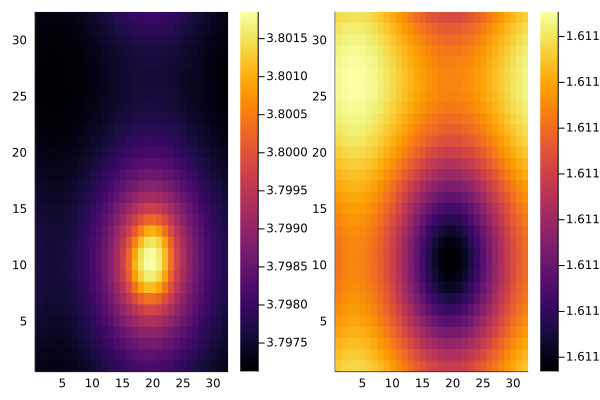

In [23]:
nt = length(sol.t)
p1 = heatmap(sol.u[nt][:,:,1]) 
p2 = heatmap(sol.u[nt][:,:,2]) 
p3 = plot(p1, p2, layout = (1, 2))

## Section 2/: Other Model 
This model was taken from [online model](https://discourse.julialang.org/t/only-explicit-solvers-work-for-stiff-pde-derived-odes-stiff-solvers-crashing/74907/3). 

In [1]:
using DifferentialEquations, LinearAlgebra, SparseArrays, Symbolics
using ModelingToolkit, SparseDiffTools, Sundials

# Generate the constants
N = 60
dx = 0.1
Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
Ay = copy(Ax)
Ax[2,1] = 2.0
Ax[end-1,end] = 2.0
Ay[1,2] = 2.0
Ay[end,end-1] = 2.0

#Parameters
f = 1.2
m = 190
q = 0.001
ϵ₁ = 0.01
ϵ = 0.01
K = 1000
Θ = 0.044
d₀ = 0.01
D₁ = 1
p = [f, m, q, ϵ, ϵ₁, D₁, d₀, K, Θ, dx]

function basic_version!(du,u,p,t)
  f, m, q, ϵ, ϵ₁, D₁, d₀, K, Θ, dx = p
  D₂ = D₁/d₀*(1 + (K-1)/(1+3/Θ))^(-3/2)
  c₁ = @view u[:,:,1]
  c₂ = @view u[:,:,2]
  dc₁ = @view du[:,:,1]
  dc₂ = @view du[:,:,2]
  
  Δ₁ = (1/dx^2)*D₁*(Ay*c₁ + c₁*Ax)
  Δ₂ = (1/dx^2)*D₂*(Ay*c₂ + c₂*Ax)
  @. dc₁ = Δ₁ .+ 1/ϵ*(f*c₂.*(q .- c₁)./(q .+ c₁) .+ c₁ .* (1 .- m*c₂)./(1 .- m*c₂ .+ ϵ₁) .- c₁.^2)
  @. dc₂ = Δ₂ .+ c₁ .* (1 .- m*c₂)./(1 .- m*c₂ .+ ϵ₁) .- c₂
end

tspan = (0.0,0.1)
u0 = rand(Float64, (N,N,2))

# Jacobian Approach
du0 = similar(u0)
sparsity_pattern = Symbolics.jacobian_sparsity(basic_version!,du0,u0,p,0.0)
jac_sparsity = Float64.(sparse(sparsity_pattern))
colorvec = matrix_colors(jac_sparsity)
@show maximum(colorvec)
f = ODEFunction(basic_version!;jac_prototype=jac_sparsity,colorvec=colorvec)
prob = ODEProblem(f,u0,tspan,p)
## Solve!
println("Solving")
@time sol = solve(prob,Tsit5(), saveat=range(0, stop=tspan[2], length=101)) 

maximum(colorvec) = 11
Solving
  8.231942 seconds (24.16 M allocations: 4.166 GiB, 5.52% gc time, 69.31% compilation time)


retcode: Success
Interpolation: 1st order linear
t: 101-element Vector{Float64}:
 0.0
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01
 0.011
 0.012
 ⋮
 0.089
 0.09
 0.091
 0.092
 0.093
 0.094
 0.095
 0.096
 0.097
 0.098
 0.099
 0.1
u: 101-element Vector{Array{Float64, 3}}:
 [0.7076034123397663 0.9564899707154679 … 0.7215076367173026 0.7092163198910848; 0.2579881850786483 0.5799738261343077 … 0.7508300262548602 0.21572383494631797; … ; 0.2977546185742579 0.599643441901436 … 0.553149691992006 0.5400194793034347; 0.22927458429938796 0.8818201513931814 … 0.04249753752728469 0.23539758449447068]

[0.2501744663616947 0.6315521479247244 … 0.26802190381235547 0.16540991942853056; 0.6782632013375511 0.4513318785821814 … 0.9144654797013214 0.5492964413781376; … ; 0.7038393817318565 0.37270566213884937 … 0.11666888541195486 0.6976992142047029; 0.7883530328340809 0.8512720330357848 … 0.172865733433063 0.6792183794653297]
 [0.6411587309202016 0.7566913370120061 … 0.667728261544

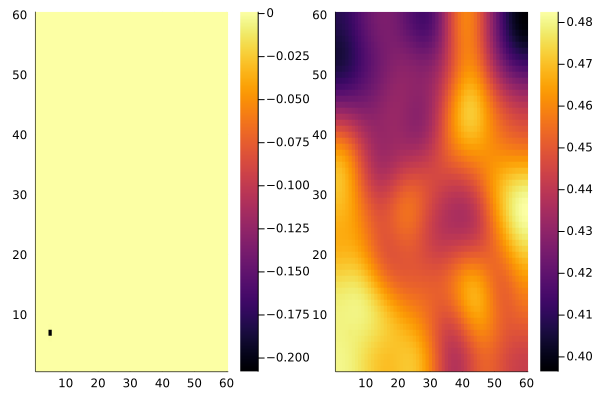

In [4]:
nt = length(sol.t)
p1 = heatmap(sol.u[nt][:,:,1]) 
p2 = heatmap(sol.u[nt][:,:,2]) 
p3 = plot(p1, p2, layout = (1, 2))